In [3]:
import matplotlib.pyplot as plt
from datasets import load_dataset, DownloadManager, Image, load_from_disk, concatenate_datasets
import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
from typing import Union, List


%matplotlib inline

## Load datasets

In [7]:
# method used for adding a column called label to a huggingface dataset
def add_label(dataset_row, label):
    dataset_row['label'] = label
    return dataset_row

def resize_images(dataset_row):
    # the diffusion model generates images of size 512 x 512
    dataset_row['image'] = [image.resize((512, 512)) for image in dataset_row['image']]
    return dataset_row


#### Clothing dataset

Size: 14904
outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket
Image Size: (512, 512)


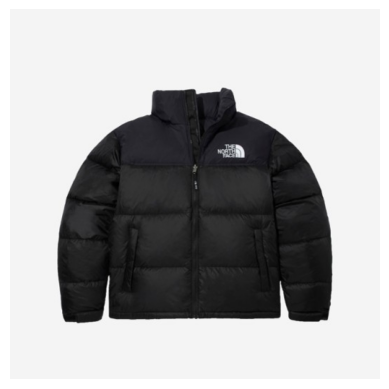

In [2]:
def get_clothes_dataset():
    dataset_path = './clothes_dataset'
    try:
        clothes_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        clothes_dataset = load_dataset("hahminlew/kream-product-blip-captions", split="train") # only has a train split
        clothes_dataset = clothes_dataset.map(lambda row: add_label(row, 'clothes')).map(function=resize_images, batched=True, num_proc=6)
        clothes_dataset.save_to_disk(dataset_path)
    return clothes_dataset

clothes_dataset = get_clothes_dataset()
sample = clothes_dataset[0]
clothes_dataset_size = len(clothes_dataset)
print('Size:', clothes_dataset_size)
print(sample["text"])
print('Image Size:', sample['image'].size)
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 525 x 525 pixels but are resized to 512 x 512

#### Cartoon pixel art dataset

Generating train split:   0%|          | 0/49859 [00:00<?, ? examples/s]

a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background
49859


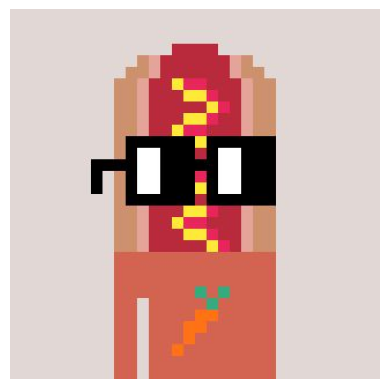

In [5]:
def get_pixelart_dataset(clothes_dataset_size):
    dataset_path = './pixelart_dataset'
    try:
        pixelart_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        pixelart_dataset = load_dataset('m1guelpf/nouns', split='train') # only has a train split too
        pixelart_dataset = pixelart_dataset.select(range(clothes_dataset_size)).map(lambda row: add_label(row, 'pixel_art')).map(
            function=resize_images, batched=True, num_proc=6)
        pixelart_dataset.save_to_disk(dataset_path)
    return pixelart_dataset

pixelart_dataset = get_pixelart_dataset()
sample = pixelart_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 320 x 320 pixels but are resized to 512 x 512

#### Realistic photograph dataset

In [ ]:
def get_photograph_dataset(clothes_dataset_size):
    dataset_path = './photograph_dataset'

    try:
        photograph_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        photograph_dataset = load_dataset('1aurent/unsplash-lite-palette', split='train') # also, this dataset only has train split
        photograph_dataset = photograph_dataset.select(range(clothes_dataset_size))

        def download_image(url: Union[str, List[str]], dl_manager: DownloadManager):
            filenames = dl_manager.download(url)
            return {"image": filenames}
        
        photograph_dataset = photograph_dataset.map(
            function=download_image,
            input_columns=["url"],
            fn_kwargs={
                "dl_manager": DownloadManager(),
            },
            batched=True,
            num_proc=6,
        )
        photograph_dataset = photograph_dataset.cast_column(
            column="image",
            feature=Image(),
        ).map(function=resize_images, batched=True, num_proc=6)
        photograph_dataset = photograph_dataset.remove_columns(['url', 'palettes'])
        photograph_dataset = photograph_dataset.rename_column('ai_description', 'text').map(lambda row: add_label(row, 'photographs'))
        photograph_dataset.save_to_disk(dataset_path)
    return photograph_dataset
    

In [2]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    # this tuple is what is returned on each data loader iteration
    return texts, images, labels
    
def get_finetuning_dataloaders(train_split=0.5, val_split=0.1, calib_split=0.2, batch_size=4):
    """
    ACTUALLY, JUST USE THE finetune.sh script to finetune instead of using these dataloders
    Returns (ft_clothes_train_loader, ft_clothes_val_loader, ft_clothes_calib,
             ft_pixelart_train_loader, ft_pixelart_val_loader, ft_pixelart_calib, 
             ft_photographs_train_loader, ft_photographs_val_loader, ft_photographs_calib)
    
    These dataloaders are used for finetuning the expert models
    """
    # train split size is 0.5 for 50% of data by default
    # val split size is 10% of data
    
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
    
    # Split dataset to get finetuning train/val splits
    
    ft_split_clothes = clothes_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_clothes_train_val_calib = ft_split_clothes['train'].train_test_split(test_size=calib_split)
    ft_split_clothes_train_val = ft_split_clothes_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_clothes_train, ft_clothes_val, ft_clothes_calib = ft_split_clothes_train_val['train'], ft_split_clothes_train_val['test'], ft_split_clothes_train_val_calib['test']
    
    ft_split_pixelart = pixelart_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_pixelart_train_val_calib = ft_split_pixelart['train'].train_test_split(test_size=calib_split)
    ft_split_pixelart_train_val = ft_split_pixelart_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_pixelart_train, ft_pixelart_val, ft_pixelart_calib = ft_split_pixelart_train_val['train'], ft_split_pixelart_train_val['test'], ft_split_pixelart_train_val_calib['test']
    
    ft_split_photographs = photograph_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_photographs_train_val_calib = ft_split_photographs['train'].train_test_split(test_size=calib_split)
    ft_split_photographs_train_val = ft_split_photographs_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_photographs_train, ft_photographs_val, ft_photographs_calib = ft_split_photographs_train_val['train'], ft_split_photographs_train_val['test'], ft_split_photographs_train_val_calib['test']
    
    # Get dataloaders for ft train/val splits
    ft_clothes_train_loader = DataLoader(ft_clothes_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_clothes_val_loader = DataLoader(ft_clothes_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_pixelart_train_loader = DataLoader(ft_pixelart_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_pixelart_val_loader = DataLoader(ft_pixelart_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_photographs_train_loader = DataLoader(ft_photographs_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_photographs_val_loader = DataLoader(ft_photographs_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return ft_clothes_train_loader, ft_clothes_val_loader, ft_clothes_calib, \
        ft_pixelart_train_loader, ft_pixelart_val_loader, ft_pixelart_calib, \
        ft_photographs_train_loader, ft_photographs_val_loader, ft_photographs_calib
    

def get_dataloaders(train_split=0.7, test_split=0.2, val_split=0.1, batch_size=4):
    """
    Returns (train_loader, val_loader, test_loader) 
    
    These dataloaders are used for training/testing selection network
    """
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
        
    # Example split proportions for selection network dataloaders
    split_proportions = {'train': train_split, 'test': test_split, 'validation': val_split}

    # Split datasets
    split_clothes = clothes_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_clothes_val_test = split_clothes['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    clothes_train, clothes_validation, clothes_test = split_clothes['train'], split_clothes_val_test['train'], split_clothes_val_test['test']

    split_pixelart = pixelart_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_pixelart_val_test = split_pixelart['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    pixelart_train, pixelart_validation, pixelart_test = split_pixelart['train'], split_pixelart_val_test['train'], split_pixelart_val_test['test']

    split_photographs = photograph_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_photographs_val_test = split_photographs['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    photographs_train, photographs_validation, photographs_test = split_photographs['train'], split_photographs_val_test['train'], split_photographs_val_test['test']
    
    concatenated_train = concatenate_datasets([clothes_train, pixelart_train, photographs_train])
    concatenated_val = concatenate_datasets([clothes_validation, pixelart_validation, photographs_validation])
    concatenated_test = concatenate_datasets([clothes_test, pixelart_test, photographs_test])
    
    train_loader = DataLoader(concatenated_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(concatenated_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(concatenated_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, validation_loader, test_loader

### Testing out stable diffusion model

In [8]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
ORIGINAL_MODEL_PATH = './models/original'

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(model_id) # torch_dtype=torch.float16 is a kwarg we can use

# sometimes, clip will flag the image as being nsfw. In this case, the model will produce a completely black image 
# this is harmful for training, so for training purposes we will temporarily disable the nsfw safety checker
pipe.safety_checker = lambda images, clip_input: (images, [False for _ in images]) 
pipe.save_pretrained(ORIGINAL_MODEL_PATH)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

self.safety_checker=<function <lambda> at 0x7fa1d22eb3a0> of type <class 'function'> cannot be saved.


  0%|          | 0/50 [00:00<?, ?it/s]

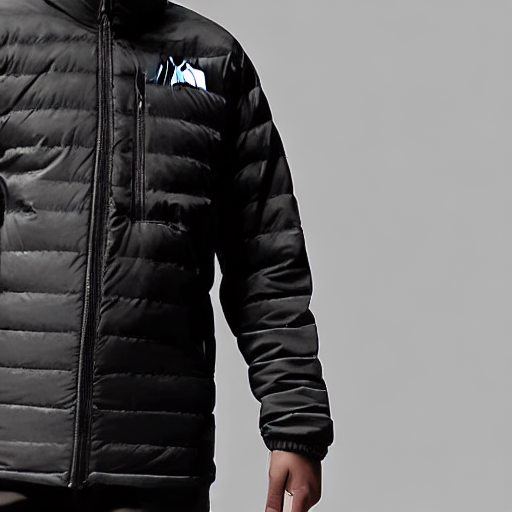

In [10]:
# this is the first dataset row's prompt of the clothing dataset
prompt = "outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket"
image = pipe(prompt).images[0]
image # 512 x 512 pixel image produced by diffusion model

### Testing out Quantizaton

In [4]:
from tqdm import tqdm
from PIL import Image
import glob
import numpy as np
import torch
import torchvision as tv
import onnx
import onnxruntime as ort
from onnxruntime import quantization

In [11]:
pipe = StableDiffusionPipeline.from_pretrained(ORIGINAL_MODEL_PATH)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [12]:
output = pipe(['A person in the desert', 'a chocolate bar'])
output

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FA1D220EE20>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7FA1D220EF10>], nsfw_content_detected=None)

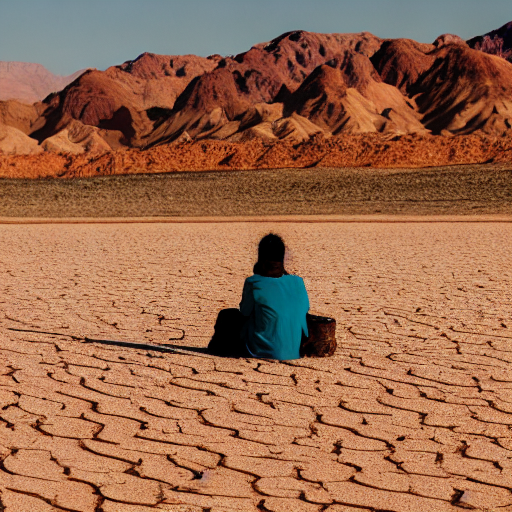

In [13]:
output.images[0]

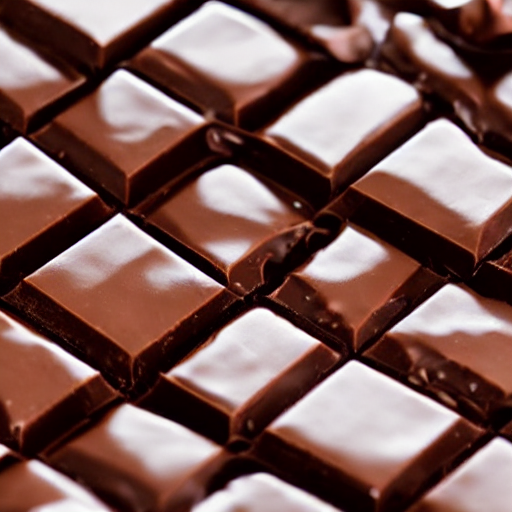

In [14]:
output.images[1]

In [19]:
from transformers import CLIPTextModel, CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained(ORIGINAL_MODEL_PATH, subfolder="tokenizer")
captions = ['A person in the desert']
tokenized_input = tokenizer(captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")

In [22]:
tokenizer

CLIPTokenizer(name_or_path='./models/original', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}